# Eclipsing binary: `pymc3` solution for the maps

In this notebook, we're going to do MCMC to infer the surface maps of two stars in an eclipsing binary given the light curve of the system. We generated the data in [this notebook](EclipsingBinary_Generate.ipynb). Note that here we assume we know everything else about the system (the orbital parameters, the limb darkening coefficients, etc.), so the only unknown parameters are the maps of the two stars, which are expressed in `starry` as vectors of spherical harmonic coefficients. In a future tutorial we'll explore a more complex inference problem where we have uncertainties on all the parameters.

Let's begin with some imports. **Note that in order to do inference with pymc3, we need to enable lazy evaluation.** That's because `pymc3` requires derivatives of the likelihood function, so we need to use the fancy `theano` computational graph to perform backpropagation on the `starry` model. All this means in practice is that we'll have to call `.eval()` in some places to get numerical values out of the parameters.

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import os
import starry
from corner import corner

np.random.seed(12)
starry.config.lazy = True
starry.config.quiet = True

## Load the data

Let's load the EB dataset:

In [5]:
# Run the Generate notebook if needed
if not os.path.exists("eb.npz"):
    import nbformat
    from nbconvert.preprocessors import ExecutePreprocessor

    with open("EclipsingBinary_Generate.ipynb") as f:
        nb = nbformat.read(f, as_version=4)
    ep = ExecutePreprocessor(timeout=600, kernel_name="python3")
    ep.preprocess(nb);

In [6]:
data = np.load("eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]

Next, we instantiate the primary, secondary, and system objects. Recall that we assume we know the true values of all the orbital parameters and star properties, *except* for the two surface maps. Note that we are instantiating the `starry` objects within a `pm.Model()` context so that `pymc3` can keep track of all the variables.

In [7]:
with pm.Model() as model:

    # Primary
    pri = starry.Primary(
        starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
        r=A["r"],
        m=A["m"],
        prot=A["prot"],
    )
    pri.map[1:] = A["u"]

    # Secondary
    sec = starry.Secondary(
        starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc"]),
        r=B["r"],
        m=B["m"],
        porb=B["porb"],
        prot=B["prot"],
        t0=B["t0"],
        inc=B["inc"],
    )
    sec.map[1:] = B["u"]

    # System
    sys = starry.System(pri, sec)

Here's the light curve we're going to do inference on:

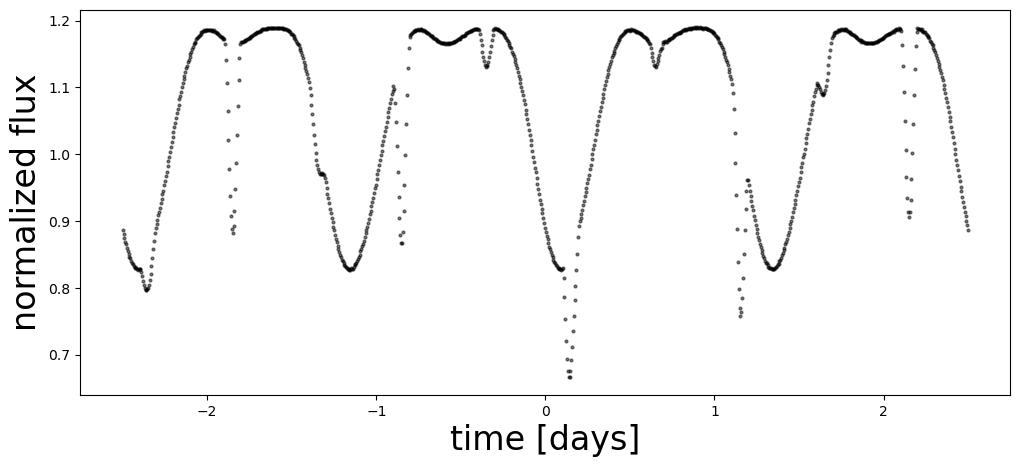

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

## Define the `pymc3` model

Now we define the full `pymc3` model. If you've never used `pymc3` before, Dan Foreman-Mackey's [exoplanet package documentation](https://exoplanet.dfm.io/en/stable/) has lots of nice tutorials on how to use `pymc3` to do inference. The basic idea here is we define our variables by assigning priors to them; we use a `pm.MvNormal` for both the primary and secondary maps. This is a multi-variate normal (Gaussian) distribution, which happens to be a convenient prior to place on spherical harmonic coefficients because of its close relationship to the *power spectrum* of the map. In particular, if the Gaussian prior is zero-mean and its covariance is diagonal with constant entries for each degree $l$ (as we assume below), this is equivalent to an isotropic prior whose power spectrum is given by those entries on the diagonal. Note that for simplicity we are assuming a *flat* power spectrum, meaning we place the same prior weight on all spatial scales. So the covariance of our Gaussian is as simple as it can be: it's just $\lambda I$, where $\lambda = 10^{-2}$ is the prior variance of the spherical harmonic coefficients and $I$ is the identity matrix. The scalar $\lambda$ is essentially a regularization parameter: by making it small, we ensure that the spherical harmonic coefficients stay close to zero, which is usually what we want for physical maps.

You'll note there's also a call to `pm.Deterministic`, which just keeps track of variables for later (in this case, we'll have access to the value of `flux_model` for every iteration of the chain once we're done; this is useful for plotting). And finally, there's a call to `pm.Normal` in which we specify our `observed` values, their standard deviation `sd`, and the mean vector `mu`, which is our `starry` flux model. This normal distribution is our chi-squared term: we're telling `pymc3` that our data is normally distributed about our model with some (observational) uncertainty.

In [9]:
with pm.Model() as model:

    # The amplitude of the primary
    pri.map.amp = pm.Normal("pri_amp", mu=1.0, sd=0.1)

    # The Ylm coefficients of the primary
    # with a zero-mean isotropic Gaussian prior
    ncoeff = pri.map.Ny - 1
    pri_mu = np.zeros(ncoeff)
    pri_cov = 1e-2 * np.eye(ncoeff)
    pri.map[1:, :] = pm.MvNormal("pri_y", pri_mu, pri_cov, shape=(ncoeff,))

    # The amplitude of the secondary
    sec.map.amp = pm.Normal("sec_amp", mu=0.1, sd=0.01)

    # The Ylm coefficients of the secondary
    # with a zero-mean isotropic Gaussian prior
    ncoeff = sec.map.Ny - 1
    sec_mu = np.zeros(ncoeff)
    sec_cov = 1e-2 * np.eye(ncoeff)
    sec.map[1:, :] = pm.MvNormal("sec_y", sec_mu, sec_cov, shape=(ncoeff,))

    # Compute the flux
    flux_model = sys.flux(t=t)

    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=sigma, observed=flux)

Now that we've specified the model, it's a good idea to run a quick gradient descent to find the MAP (maximum a posteriori) solution. This will give us a decent starting point for the inference problem.

In [10]:
with model:
    map_soln = pmx.optimize()

optimizing logp for variables: [sec_y, sec_amp, pri_y, pri_amp]


message: Desired error not necessarily achieved due to precision loss.
logp: -33047316.91100836 -> 6285.775857961196


Note the dramatic increase in the value of the log posterior!
Let's plot the MAP model alongside the data and the initial guess (note that we're doing quite well).

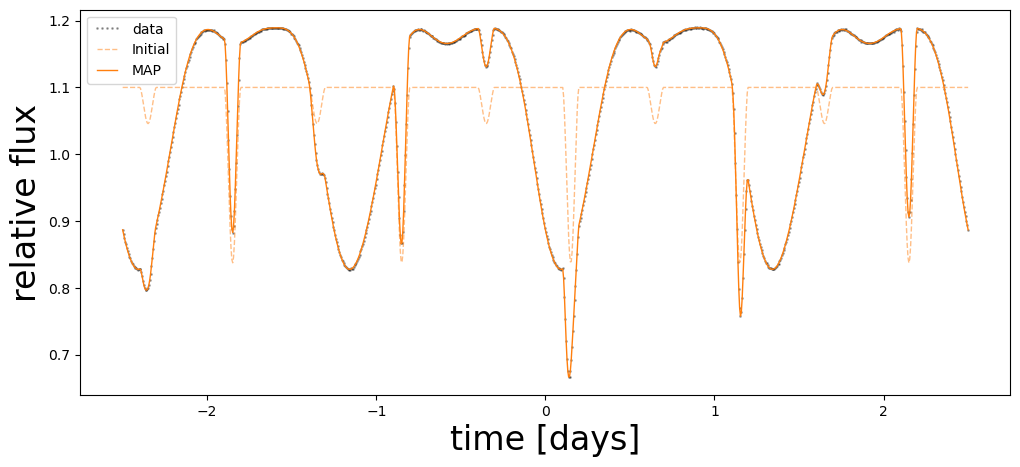

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

We can also plot the corresponding maps: note that we recover the spots *really well*!

In [12]:
map = starry.Map(ydeg=A["ydeg"])
map.inc = A["inc"]
map.amp = map_soln["pri_amp"]
map[1:, :] = map_soln["pri_y"]
map.show(theta=np.linspace(0, 360, 50))

In [13]:
map = starry.Map(ydeg=B["ydeg"])
map.inc = B["inc"]
map.amp = map_soln["sec_amp"]
map[1:, :] = map_soln["sec_y"]
map.show(theta=np.linspace(0, 360, 50))

## MCMC sampling

We have an optimum solution, but we're really interested in the *posterior* over surface maps (i.e., an understanding of the uncertainty of our solution). We're therefore going to do MCMC sampling with `pymc3`. This is easy: within the `model` context, we just call `pmx.sample`. The number of tuning and draw steps below are quite small since I wanted this notebook to run quickly; try increasing them by a factor of a few to get more faithful posteriors.

In [14]:
with model:
    trace = pmx.sample(tune=500, draws=500, start=map_soln, chains=4, target_accept=0.9)

/pdo/users/pablomer/miniconda3/envs/starry-env-fromgit/lib/python3.9/site-packages/deprecat/classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sec_y, sec_amp, pri_y, pri_amp]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 372 seconds.
The acceptance probability does not match the target. It is 0.9999827856134661, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999938204770501, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999658209443851, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999936890088212, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


We can look at `pm.summary` to check if things converged. In particular, we're looking for a large number of effective samples `ess` for all parameters and a value of `r_hat` that is very close to one.

In [15]:
varnames = ["pri_amp", "pri_y", "sec_amp", "sec_y"]
display(pm.summary(trace, var_names=varnames).head())
display(pm.summary(trace, var_names=varnames).tail())

Got error No model on context stack. trying to find log_likelihood in translation.
/pdo/users/pablomer/miniconda3/envs/starry-env-fromgit/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pri_amp,1.001,0.003,0.996,1.004,0.001,0.001,5.0,16.0,3.01
pri_y[0],-0.004,0.002,-0.007,-0.002,0.001,0.001,4.0,13.0,4.06
pri_y[1],-0.112,0.001,-0.113,-0.110,0.001,0.000,5.0,14.0,3.07
pri_y[2],0.065,0.001,0.064,0.066,0.000,0.000,4.0,11.0,3.44
pri_y[3],0.003,0.002,0.001,0.006,0.001,0.001,5.0,12.0,3.08


Got error No model on context stack. trying to find log_likelihood in translation.
/pdo/users/pablomer/miniconda3/envs/starry-env-fromgit/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sec_y[30],0.006,0.004,-0.002,0.009,0.002,0.002,5.0,13.0,3.26
sec_y[31],0.045,0.004,0.037,0.048,0.002,0.002,5.0,14.0,3.24
sec_y[32],-0.010,0.007,-0.020,-0.002,0.003,0.003,4.0,11.0,3.44
sec_y[33],0.044,0.008,0.031,0.052,0.004,0.003,4.0,11.0,3.55
sec_y[34],-0.042,0.004,-0.048,-0.039,0.002,0.001,5.0,25.0,3.00


The number of effective samples for some of the parameters is quite small, so in practice we should run this chain for longer (an exercise for the reader!) But let's carry on for now, keeping in mind that our posteriors will be quite noisy.

Let's plot the model for 24 random samples from the chain. Note that the lines are so close together that they're indistinguishable!

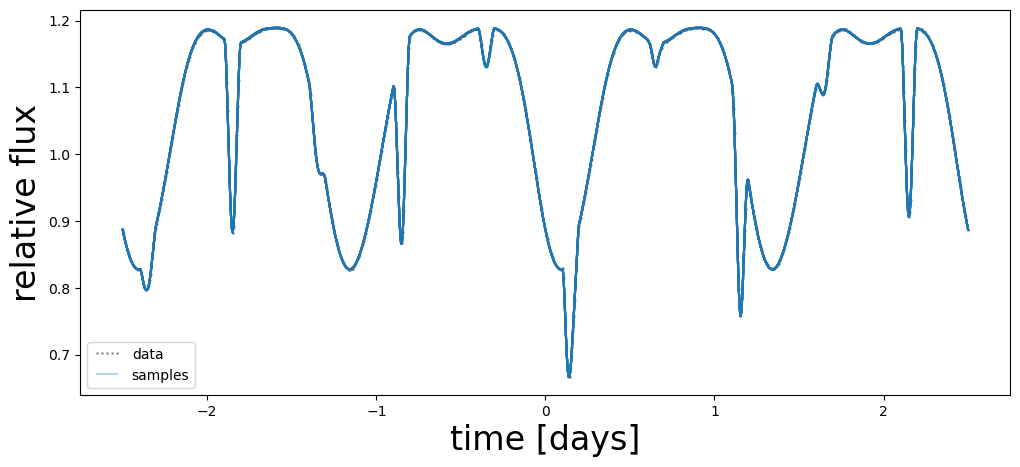

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=2, label="data")
label = "samples"
for i in np.random.choice(range(len(trace["flux_model"])), 24):
    plt.plot(t, trace["flux_model"][i], "C0-", alpha=0.3, label=label)
    label = None
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

Let's compare the *mean* map and a *random* sample to the true map for each star:

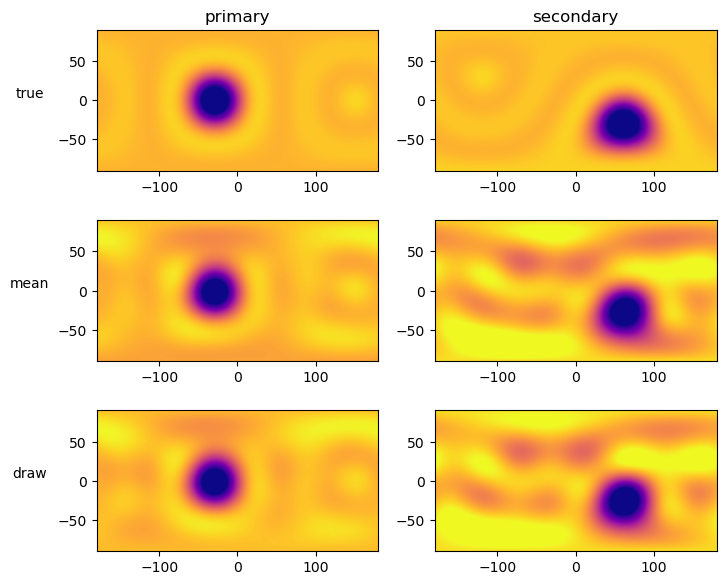

In [17]:
# Random sample
np.random.seed(0)
i = np.random.randint(len(trace["pri_y"]))

map = starry.Map(ydeg=A["ydeg"])
map[1:, :] = np.mean(trace["pri_y"], axis=0)
map.amp = np.mean(trace["pri_amp"])
pri_mu = map.render(projection="rect").eval()
map[1:, :] = trace["pri_y"][i]
map.amp = trace["pri_amp"][i]
pri_draw = map.render(projection="rect").eval()
map[1:, :] = A["y"]
map.amp = A["amp"]
pri_true = map.render(projection="rect").eval()

map = starry.Map(ydeg=B["ydeg"])
map[1:, :] = np.mean(trace["sec_y"], axis=0)
map.amp = np.mean(trace["sec_amp"])
sec_mu = map.render(projection="rect").eval()
map[1:, :] = trace["sec_y"][i]
map.amp = trace["sec_amp"][i]
sec_draw = map.render(projection="rect").eval()
map[1:, :] = B["y"]
map.amp = B["amp"]
sec_true = map.render(projection="rect").eval()

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

Looks pretty good! There are obvious artifacts (there are tons of degeneracies in this problem), but we've definitely recovered the spots, with some uncertainty. Recall that our chains weren't well converged! Run this notebook for longer to get more faithful posteriors.

Finally, here's a corner plot for the first several coefficients of the primary map. You can see that all the posteriors are nice and Gaussian, with some fairly strong correlations (the degeneracies I mentioned above):

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


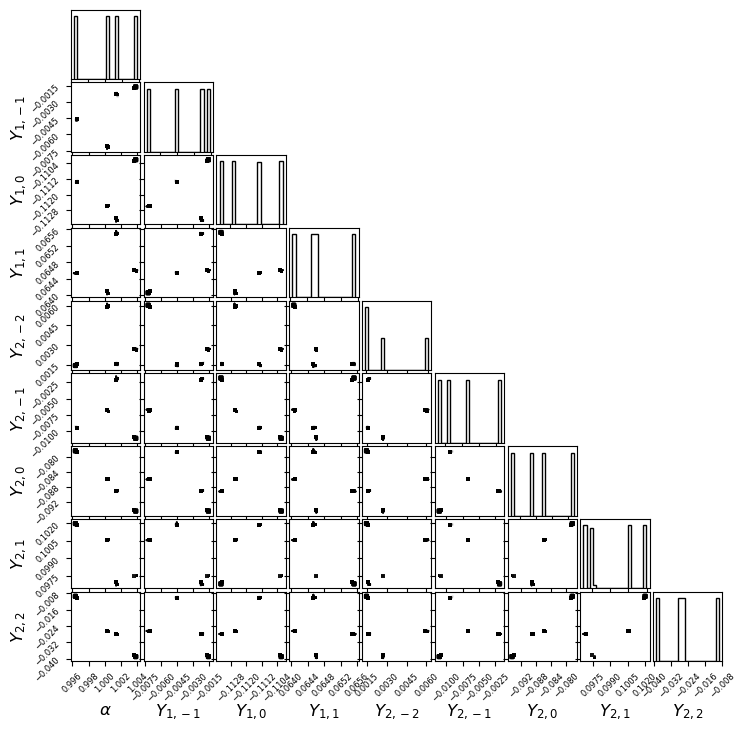

In [18]:
fig, ax = plt.subplots(9, 9, figsize=(7, 7))
labels = [r"$\alpha$"] + [
    r"$Y_{%d,%d}$" % (l, m)
    for l in range(1, pri.map.ydeg + 1)
    for m in range(-l, l + 1)
]
samps = np.hstack((trace["pri_amp"].reshape(-1, 1), trace["pri_y"][:, :8]))
corner(samps, fig=fig, labels=labels)
for axis in ax.flatten():
    axis.xaxis.set_tick_params(labelsize=6)
    axis.yaxis.set_tick_params(labelsize=6)
    axis.xaxis.label.set_size(12)
    axis.yaxis.label.set_size(12)
    axis.xaxis.set_label_coords(0.5, -0.6)
    axis.yaxis.set_label_coords(-0.6, 0.5)

That's it! While sampling with `pymc3` is fairly fast, the problem of inferring a surface map when all other parameters are known is a **linear problem**, which means it actually has an *analytic* solution! In the following [notebook](EclipsingBinary_Linear.ipynb), we show how to take advantage of this within `starry` to do extremely fast inference.